# Customer buying behavior prediction

----
Customer buying behaviour refers to the actions and decisions made by a customer when purchasing a product or service. It involves the psychological, social, and economic factors that influence a customer's decision-making process, such as their needs, wants, preferences, budget, and past experiences. Understanding customer buying behaviour is essential for businesses to develop effective marketing strategies and improve their sales performance.

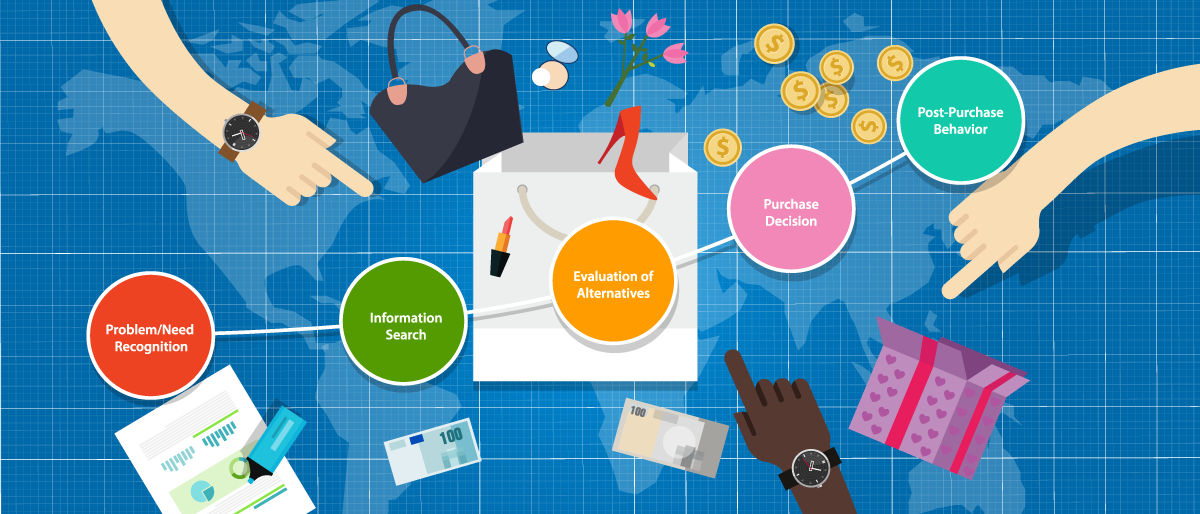




#Import Libraries 

In [2]:
import numpy as np # Multi-dimensional array object
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Visualization
import math #extends the list of mathematical functions.
import scipy.stats as stats
from sklearn.metrics import mutual_info_score # to compute mutual information between features
from sklearn.model_selection import train_test_split # split the data in training and testing sets
import category_encoders as ce # to encode categorical variables
from sklearn.ensemble import RandomForestClassifier # Random Forest classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression classifier
from sklearn.metrics import classification_report # to generate the classification report
from imblearn.over_sampling import SMOTE # to make the data more balanced using oversampling
from imblearn.over_sampling import ADASYN # to make the data more balanced using oversampling
from sklearn.preprocessing import RobustScaler # to scale the features
from sklearn.preprocessing import FunctionTransformer # to apply a function to the data
from sklearn.compose import ColumnTransformer # to apply transformers to specific columns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve # to evaluate model performance
from xgboost import XGBClassifier # XGBoost classifier
import itertools # used to iterate over data structures that can be stepped over using a for-loop.
from catboost import CatBoostClassifier # CatBoost classifier
from sklearn.metrics import roc_auc_score # to compute ROC AUC score
from sklearn.model_selection import learning_curve # to generate learning curves
from sklearn.model_selection import RandomizedSearchCV # to perform hyperparameter tuning using randomized search
import pickle # to save and load models

#Load the dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dataset2/customer_booking.csv", encoding="ISO-8859-1")
df.head() #view the first 5 rows in the dataset

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


#Exploratory Data Analysis(EDA)

##*Data description*




To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


##*Data Exploration*

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have.

In [ ]:
# Get information of the data frame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

Fortunately, I have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

In [ ]:
print ("Number of Rows     : " ,df.shape[0])
print ("Number of Columns  : " ,df.shape[1])
print ("="*100,"\nFeatures : \n" ,df.columns.tolist())
print ("="*100,"\nMissing values :  ", df.isnull().sum().values.sum())
print ("="*100,"\nUnique values :  \n",df.nunique())
print ("="*100,"\nduplicate values :  \n",df.duplicated().sum())

Number of Rows     :  50000
Number of Columns  :  14
Features : 
 ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
Missing values :   0
Unique values :  
 num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64
duplicate values :  
 719


The data set contains 5000 observations and 14 columns.The dataset contains 719 duplicate values. 

In [ ]:
# Compute summary statistics for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


The data has variable scales so I will need to normalize it later.
Most of numerical colums have a right skewed distribution.


In [ ]:
#computes a summary of statistics pertaining to the categorical columns in datframe
df.describe(exclude='number').T

,count,unique,top,freq
sales_channel,50000,2,Internet,44382
trip_type,50000,3,RoundTrip,49497
flight_day,50000,7,Mon,8102
route,50000,799,AKLKUL,2680
booking_origin,50000,104,Australia,17872


##Data Visualization

####Visualize target column

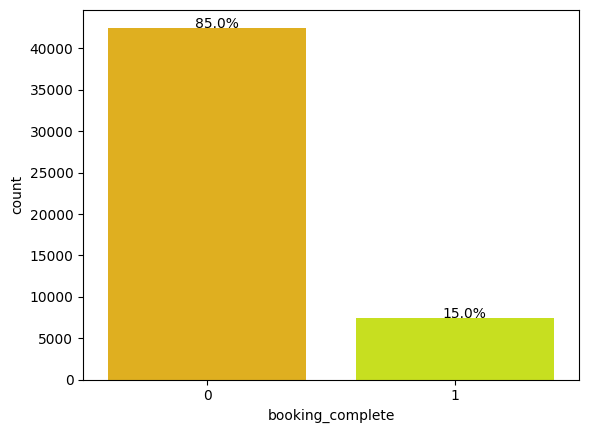

In [ ]:
# Create a countplot with percentage
ax = sns.countplot(x="booking_complete", data=df,palette=["#FFBF00", "#DFFF00"])
total = len(df["booking_complete"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() + 5
    ax.annotate(percentage, (x, y))

plt.show()


1.   About 15% of the total customers have combleted the booking.

2.   The dataset is "imbalanced" because the distribution of the target variable is not equal across different classes.




####Visualize Categorical columns

In [ ]:
# Select categorical columns only
cat_cols = df.select_dtypes(include=['category', 'object'])

# Print the categorical columns
print(cat_cols)

      sales_channel  trip_type flight_day   route booking_origin
0          Internet  RoundTrip        Sat  AKLDEL    New Zealand
1          Internet  RoundTrip        Sat  AKLDEL    New Zealand
2          Internet  RoundTrip        Wed  AKLDEL          India
3          Internet  RoundTrip        Sat  AKLDEL    New Zealand
4          Internet  RoundTrip        Wed  AKLDEL          India
...             ...        ...        ...     ...            ...
49995      Internet  RoundTrip        Sat  PERPNH      Australia
49996      Internet  RoundTrip        Sun  PERPNH      Australia
49997      Internet  RoundTrip        Sat  PERPNH      Australia
49998      Internet  RoundTrip        Mon  PERPNH      Australia
49999      Internet  RoundTrip        Thu  PERPNH      Australia

[50000 rows x 5 columns]


Create helper function to visualize the relationship of all the categorical features and the target


In [ ]:
def count_booker(feature, data, palette, size=15, ax=None):
    if ax is None:
        plt.figure(figsize=(6, 3))
        ax = plt.gca()

    sns.countplot(x=feature, data=data, hue="booking_complete", palette=palette,
                  order=data[feature].value_counts().index, ax=ax)

    ax.set_title(f'Number of Different {feature} by Booking', size=size-5)
    ax.set_xlabel(f'{feature}', size=size)
    ax.set_ylabel('Count', size=size)


#####*Sales channel column*

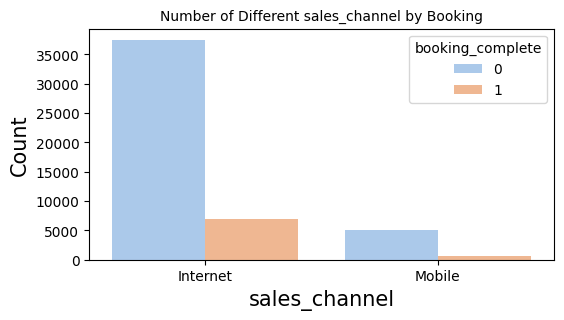

In [ ]:
count_booker(feature='sales_channel', data = df,palette="pastel")

The number of consumers who finished their booking via the Internet is bigger than the number of customers who completed their booking via mobile.

#####*Trip type column*

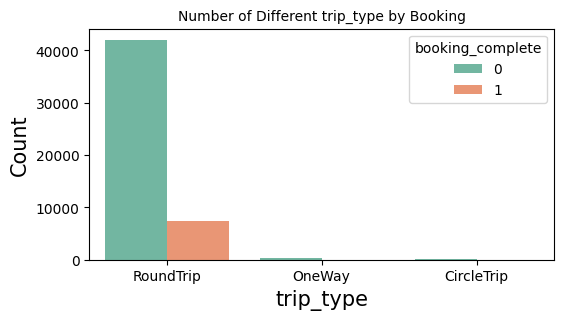

In [ ]:
count_booker(feature='trip_type', data = df,palette="Set2")



1.  The number of customers buying Round trip is significantly higher than the number of people booking other trip types.
2.   In the Round trip type, the number of customers who have not completed their booking is nearly three times the number of customers who have completed their booking.



#####*flight day column*

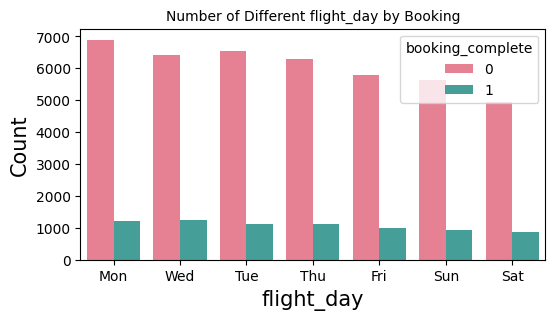

In [ ]:
count_booker(feature='flight_day', data = df,palette="husl")

From the previous plot, It looks like that on weekends the number of passengers that have completed their booking is less than on weekdays. So let's check that.


Because I want to know customer behavior to have a trip on holiday (weekend), so let's make a feature called is_weekend. if the flight day is Saturday or Sunday I give is_weekend value = 1, for another flight day I give it 0

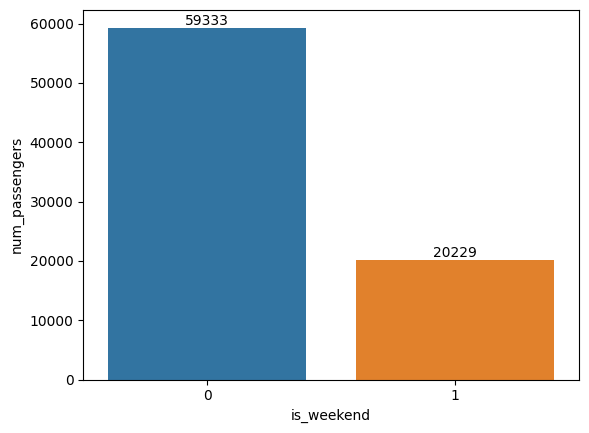

In [ ]:
# Create a copy of the original DataFrame
df_weekend=df.copy()

# Create an empty list to store whether each flight is on a weekend day or not
is_weekend = []

# Iterate over each row of the original DataFrame and check if the flight day is a weekend day
# Append 1 to the is_weekend list if it is a weekend day, and 0 otherwise
for i in range(len(df)):
    if df['flight_day'][i] == "Sat" or df['flight_day'][i] == "Sun":
        is_weekend.append(1)
    else:
        is_weekend.append(0)

# Add a new column 'is_weekend' to the new DataFrame and fill it with the values from the is_weekend list
df_weekend['is_weekend'] = is_weekend

# Group the rows of the new DataFrame by the 'is_weekend' column and calculate the total number of passengers for each group
weekend = df_weekend.groupby('is_weekend')['num_passengers'].sum().reset_index()

# Create a bar plot using Seaborn to show the total number of passengers for weekend and weekday flights
ax = sns.barplot(data = weekend, x= 'is_weekend', y= 'num_passengers')

# Add labels to the bars to show the total number of passengers for each group
ax.bar_label(ax.containers[0])

# Show the plot
plt.show()


Let's look at the average number of passengers per day:

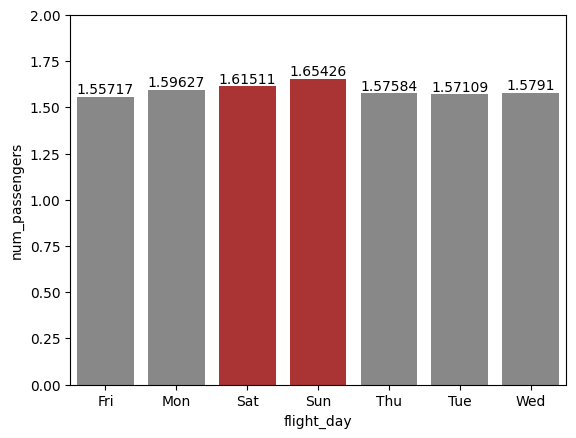

In [ ]:
# Group the rows of the DataFrame 'df' by the flight day column ('flight_day') and calculate the average number of passengers for each day
dayperday = df.groupby('flight_day')['num_passengers'].mean().reset_index()

# Create a bar plot using Seaborn to show the average number of passengers for each day
# Set the 'x' parameter to 'flight_day' and the 'y' parameter to 'num_passengers'
ax = sns.barplot(data = dayperday, x= 'flight_day', y= 'num_passengers')

# Set the face color of each bar to gray (#888888)
for bar in ax.patches:
    bar.set_facecolor('#888888')
    
# Add labels to the bars to show the average number of passengers for each day
ax.bar_label(ax.containers[0])

# Set the y-axis limits to 0 and 2
plt.ylim(0,2)

# Set the color of the bars for Saturday and Sunday (index 2 and 3) to red (#aa3333)
ax.patches[2].set_facecolor('#aa3333')
ax.patches[3].set_facecolor('#aa3333')

# Show the plot
plt.show()


from the two graphs above, on weekends the number of passengers is less than on weekdays, but the average number of passengers, weekends have a higher value than weekdays, so I need  to see the number of flights from day to day.

In [ ]:
df['flight_day'].value_counts().reset_index().sort_values(by='index')


,index,flight_day
4,Fri,6761
0,Mon,8102
6,Sat,5812
5,Sun,6554
3,Thu,7424
2,Tue,7673
1,Wed,7674


From the table above, I can see that weekends have fewer flights than weekdays, so the company need to consider adding flight schedules on weekends.

#####*Route column*

See what routes have schedules on weekends with the most passengers.

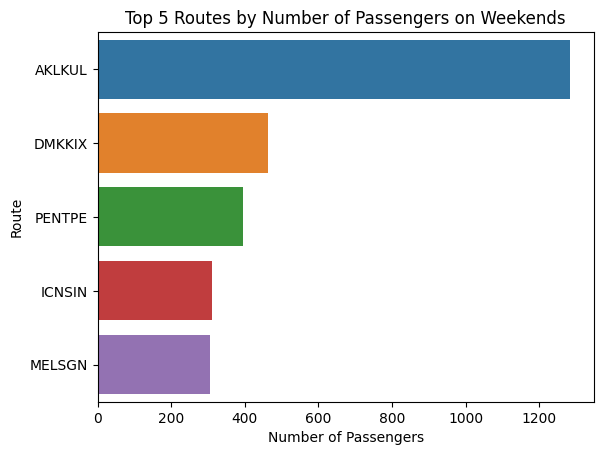

In [ ]:
# Select the top 5 routes based on the total number of passengers
route = df_weekend[df_weekend['is_weekend'] == 1].groupby('route').agg({'num_passengers' : 'sum'}).reset_index().sort_values(by='num_passengers', ascending=False)
df_route= route[:5]

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(data=df_route, y='route', x='num_passengers')

# Set the title of the plot
plt.title('Top 5 Routes by Number of Passengers on Weekends')

# Set the x-axis label
plt.xlabel('Number of Passengers')

# Set the y-axis label
plt.ylabel('Route')

# Show the plot
plt.show()


From the plot above we can see the top 5 routes that have the most passengers, so it's recommended that the company increases the number of flights to these five routes on weekends.

######*Booking origin columns*

Top Ten Countries by Bookings

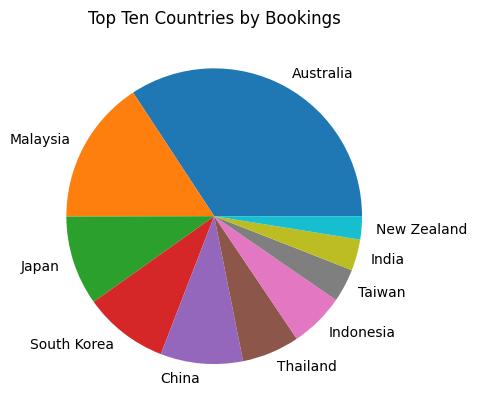

In [ ]:
booking_origin = df_weekend[df_weekend['is_weekend'] == 1].groupby('booking_origin').agg({'num_passengers' : 'sum'}).reset_index().sort_values(by='num_passengers', ascending=False)[:10]
booking_origin = booking_origin.set_index('booking_origin')['num_passengers']

# Create a pie chart showing the proportion of bookings from each origin
plt.pie(booking_origin, labels=booking_origin.index)

# Add a title to the chart
plt.title('Top Ten Countries by Bookings')

# Show the chart
plt.show()


Appearantly ,  Australia had the most bookings. 

####Visualize binary columns

In [ ]:
# select only the columns with 0 and 1 values except the target column
exclude = ['booking_complete']
df01 = df.select_dtypes(include=[np.int8, np.int16, np.int32, np.int64]).isin([0, 1]).all()
binary_columns = df01[df01 == True].drop(exclude).index.to_list()
print("Binary columns:\n", binary_columns)

Binary columns:
 ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']


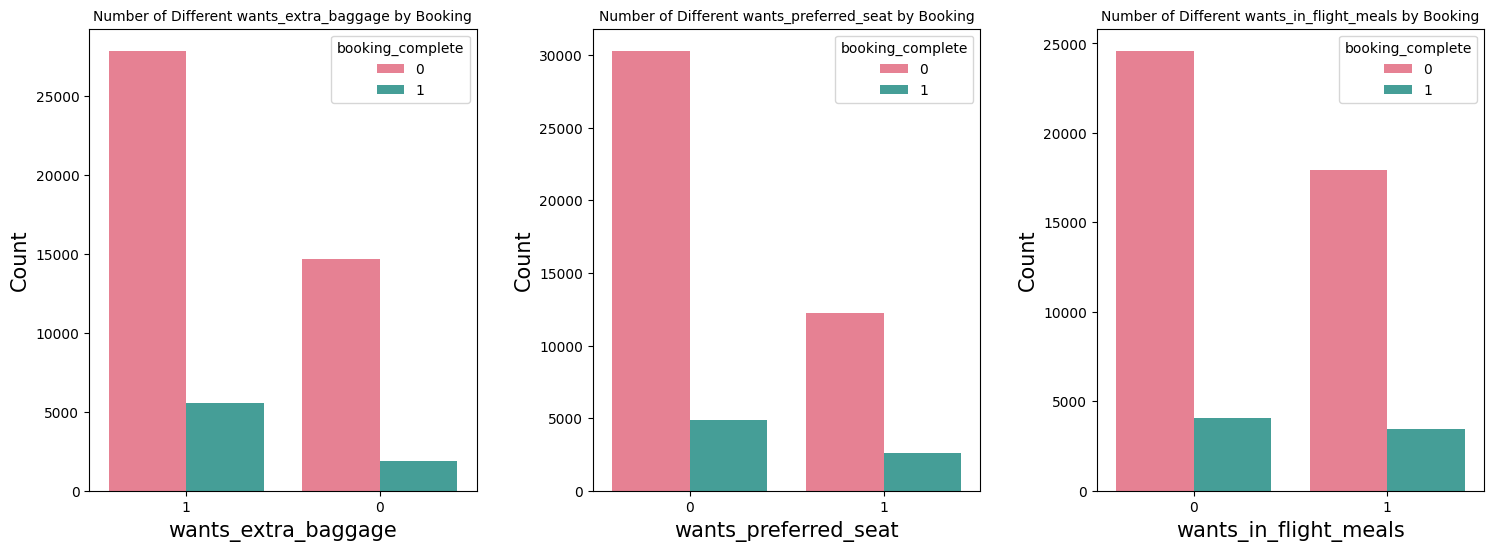

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# plot each figure in a different subplot
for i, feature in enumerate(binary_columns):
    count_booker(feature=feature, data=df, palette="husl", ax=axes[i])

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)



*   Passengers who want extra baggage and a premium seat have nearly double the completed booking rate as those who do not.
*  The wants in flight meal column don't have significant predictive power.A similar percentage of booking is shown both when a customer wants a meal or not.

#### Visualize numerical columns

In [ ]:
# Select numerical columns only that don't contain 0 and 1 values
num_cols = df.select_dtypes(include=['int64','float64']).isin([0,1]).all()
num_cols = num_cols[~num_cols].index.tolist()

# Print the numerical columns
print(num_cols)


['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']


In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 3))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['booking_complete'] == 0][feature], label= 'booking_complete: No')
    ax0.legend(loc="upper right", bbox_to_anchor=(0.6, 0.6, 0.6, 0.6),
              title='booking_complete', fancybox=True)
    ax1 = sns.kdeplot(df[df['booking_complete'] == 1][feature], label= 'booking_complete: Yes')
    ax1.legend(loc="upper right", bbox_to_anchor=(0.6, 0.6, 0.6, 0.6),
              title='booking_complete', fancybox=True)

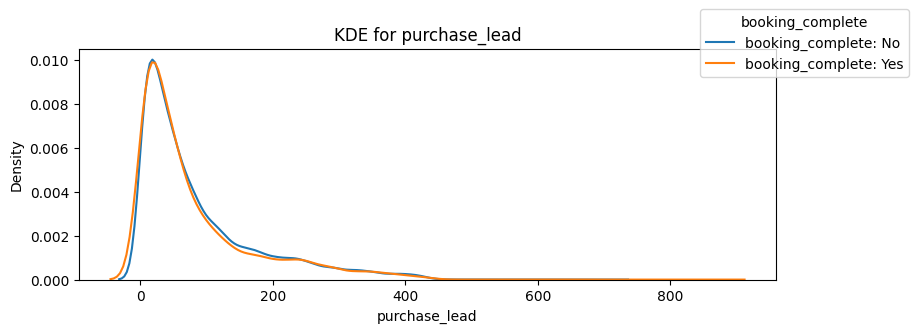

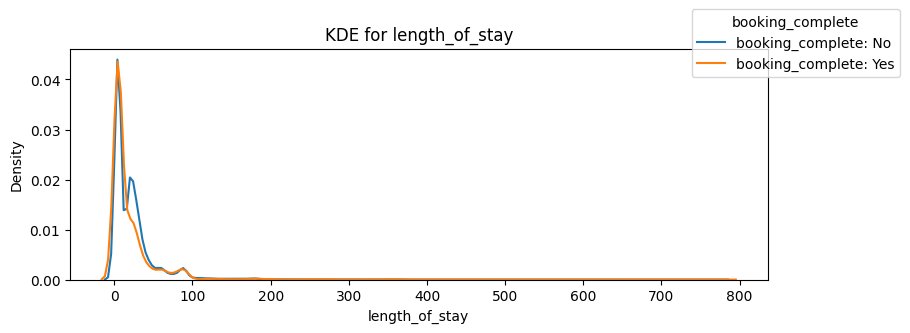

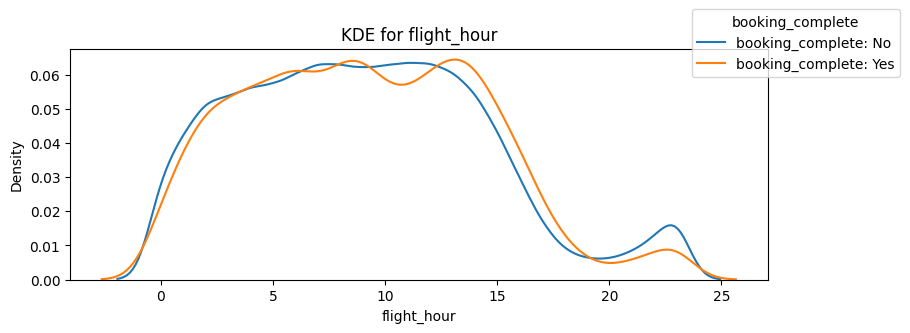

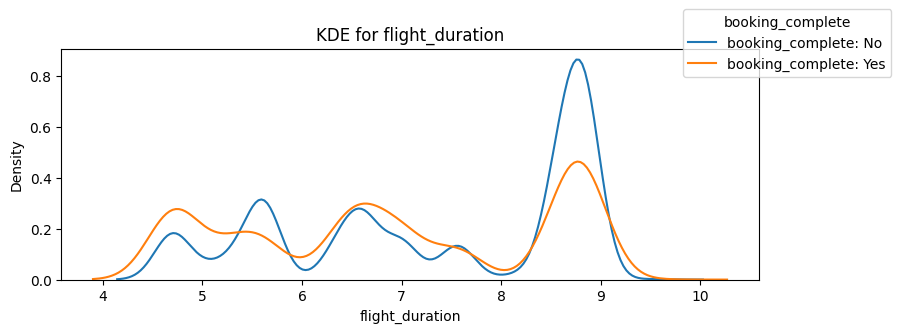

In [ ]:
kdeplot('purchase_lead')
kdeplot('length_of_stay')
kdeplot('flight_hour')
kdeplot('flight_duration')

From the above plots , I can conclude the following:

*   The greater the number of days between the date of travel and the date of booking(purchase_lead), the lower the percentage of completion of the booking.
*   The higher the number of days spent at the destination(length_of_stay), the lower the proportion of the booking completed.

*   The higher total duration of flight (in hours)(flight_hour),the lower the proportion of the booking completed.
*   The later the flight departure hour(flight_duration), the lower the proportion of the booking completed.





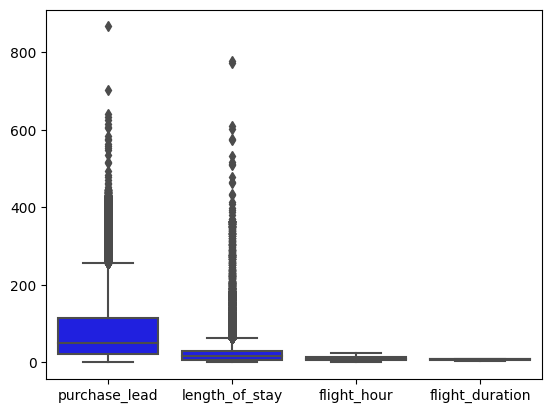

In [ ]:
df_plot = df[['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']]
plt.figure()
ax = sns.boxplot(data=df_plot,color='blue')



*   the data need normalization

*   the purchase_lead and the length of stay columns have outliers.



## Correlation

###Pearson Correlation

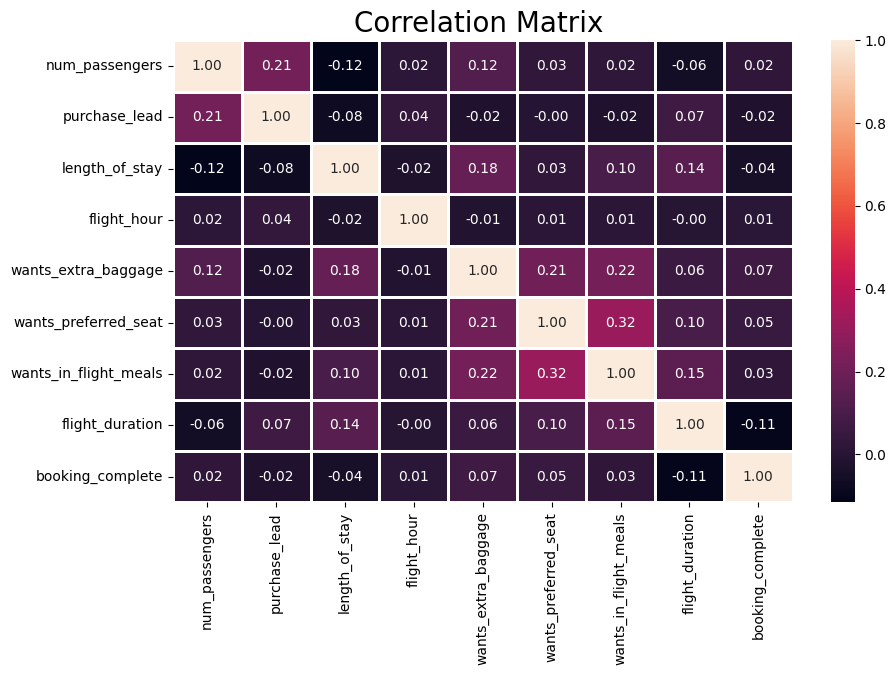

In [ ]:
#measure correlation between numerical columns
# Correlation Matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize = (10, 6))
cm = sns.heatmap(corr_matrix,
               linewidths = 1,
               annot = True, 
               fmt = ".2f")
plt.title("Correlation Matrix ", fontsize = 20)
plt.show();

There is  no multicollinearity among the numerical independent variables.

###Mutual_information

In [ ]:
# function that computes the mutual infomation score between a categorical columns and the column booking_complete
#More specifically, it quantifies the "amount of information" obtained 
#about one random variable by observing the other random variable.
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.booking_complete)

# select categorial variables excluding the response variable 
categorical_variables = df.select_dtypes(include=object)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

route             0.060984
booking_origin    0.045508
sales_channel     0.000908
trip_type         0.000516
flight_day        0.000159
dtype: float64


Based on the previous values, it seems that the "route" and "booking_origin" features have the highest mutual information with the target variable, indicating a stronger relationship. The "sales_channel" and "trip_type" features have lower mutual information values, indicating a weaker relationship. The "flight_day" feature has the lowest mutual information value, indicating almost no relationship with the target variable.

##*Data Cleaning*

let's fix the problems I discover it.

Duplicate values

In [ ]:
df[df.duplicated()]

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
196,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
316,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
384,5,Internet,RoundTrip,206,17,13,Sun,AKLKUL,Malaysia,1,0,0,8.83,0
456,1,Internet,RoundTrip,30,85,15,Fri,AKLKUL,Malaysia,1,0,0,8.83,1
513,3,Internet,RoundTrip,109,20,4,Tue,AKLKUL,Singapore,1,0,1,8.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49852,2,Internet,RoundTrip,204,6,14,Tue,PENTPE,Malaysia,1,0,0,4.67,0
49902,1,Mobile,RoundTrip,106,6,11,Fri,PENTPE,Taiwan,1,0,0,4.67,0
49934,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0
49944,1,Internet,RoundTrip,2,6,3,Thu,PENTPE,Malaysia,0,0,1,4.67,0


Their is an exact duplicate( two or more records in a dataset have the same values for all variables). So I will drop all duplicates in the dataframe and keep the first occurrence of each row.

In [ ]:
df.drop_duplicates(keep='first', inplace=True)


In [ ]:
# check if this work
df.duplicated().sum()

0

In [ ]:
# Get the number of rows after drop duplicates
df.shape[0]

49281

Convert the columns that should be converted into different data types, e.g. flight_day.

In [ ]:
# Get unique values in the 'flight_day' column
df["flight_day"].unique()


array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
# Define a mapping dictionary to convert weekdays to numeric values
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

# Map the values in the 'flight_day' column using the mapping dictionary
df["flight_day"] = df["flight_day"].map(mapping)


In [ ]:
# Check if the column converted
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  int64  
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.6+ 

Feature engineering : Create a new column

In [4]:
# Check if the flight day is a weekend day and assign 1 or 0 using np.where function
# np.where(condition, value if true, value if false)
# If flight_day is 6 or 7, return 1, else return 0
df['is_weekend'] = np.where((df['flight_day'] == 6) | (df['flight_day'] == 7), 1, 0)

In [ ]:
#Display the first five rows of the 'is_weekend' column to verify it was created correctly
df['is_weekend'] .head()

0    1
1    1
2    0
3    1
4    0
Name: is_weekend, dtype: int64

Encoding

In [ ]:
# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = [ 'sales_channel', 'trip_type']

# encode categorical variables with more than two levels using one-hot encoding
df_encoded= pd.get_dummies(df,columns = one_hot_encoding_columns)

In [ ]:
#Check shape after applying OHE
df_encoded.shape

(49281, 18)

The columns route and booking_origin have a lot of values if I used OHE with them the dimension will become 919 so I will use with catboost encoder with this columns.

In [ ]:
# Extract the target column from the encoded dataframe
target = df_encoded['booking_complete']

# Drop the target column from the encoded dataframe to create the training set
train = df_encoded.drop('booking_complete', axis=1)

# Define the CatBoostEncoder with sigma=0.5 and random_state=42
cbe_encoder = ce.cat_boost.CatBoostEncoder(sigma=0.5, random_state=42)

# Fit the CatBoostEncoder on the training set and transform the features
cbe_encoder.fit(train, target)
df_encoded = cbe_encoder.transform(train)

# Add the target column back to the encoded dataframe
df_encoded['booking_complete'] = target

# get the first few rows of the encoded dataframe
df_encoded.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,is_weekend,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip,booking_complete
0,2,262,19,7,6,0.007142,0.050094,1,0,0,5.52,1,1,0,0,0,1,0
1,1,112,20,3,6,0.007142,0.050094,0,0,0,5.52,1,1,0,0,0,1,0
2,2,243,22,17,3,0.007142,0.101787,1,1,0,5.52,0,1,0,0,0,1,0
3,1,96,31,4,6,0.007142,0.050094,0,0,1,5.52,1,1,0,0,0,1,0
4,2,68,22,15,3,0.007142,0.101787,1,0,1,5.52,0,1,0,0,0,1,0


###Oversampling the minority class using ADASYN(Adaptive Synthetic Over-sampling Technique):

In [ ]:
# Drop the 'booking_complete' column from the dataframe and store the remaining columns in X
X = df_encoded.drop(columns=['booking_complete'])

# Create a new Series y that contains only the 'booking_complete' column
y = df_encoded['booking_complete']

In [ ]:
oversample2=ADASYN(random_state=42)
X_adasyn, y_adasyn = oversample2.fit_resample(X, y)

#Split data

In [ ]:
# split the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn , test_size=0.25,random_state=42, shuffle=True)

Transformation

In [ ]:
# Apply log transformation to the numerical columns
numerical_cols = ['purchase_lead', 'length_of_stay']
X_train[numerical_cols] = np.log(X_train[numerical_cols] + 1)
X_test[numerical_cols] = np.log(X_test[numerical_cols] + 1)

Feature Scaling

In [ ]:
# create a RobustScaler object
scaler = RobustScaler()

# fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
feature_names = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_train_scaled_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,is_weekend,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
0,0.0,0.492346,1.063075,-0.375,-0.333333,-0.001199,0.700079,0.0,0.0,0.0,0.426029,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.078274,0.000000,1.000,-0.666667,0.751389,0.768109,0.0,0.0,1.0,-0.763934,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.325409,-0.550034,0.750,0.666667,0.360752,-0.280713,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.234198,0.000000,-0.875,0.000000,0.933177,0.120409,0.0,0.0,1.0,-0.632787,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.230387,-0.218425,0.375,1.333333,0.118686,0.703188,-1.0,1.0,1.0,-0.345857,1.0,0.0,0.0,0.0,0.0,0.0


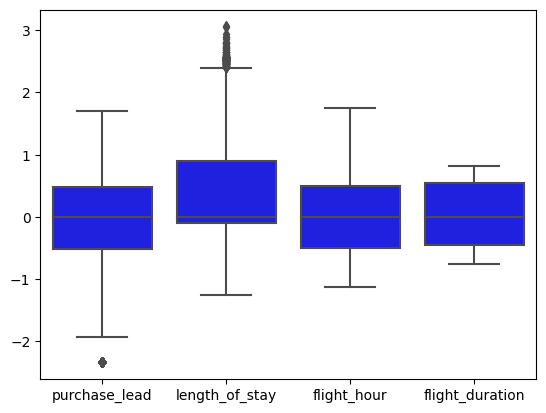

In [ ]:
df_plot = X_train_scaled_df[['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']]
plt.figure()
ax = sns.boxplot(data=df_plot,color='blue')

Now the range of features are normalized and the impact of outliers have reduced after applying log transformation.

Feature Importance

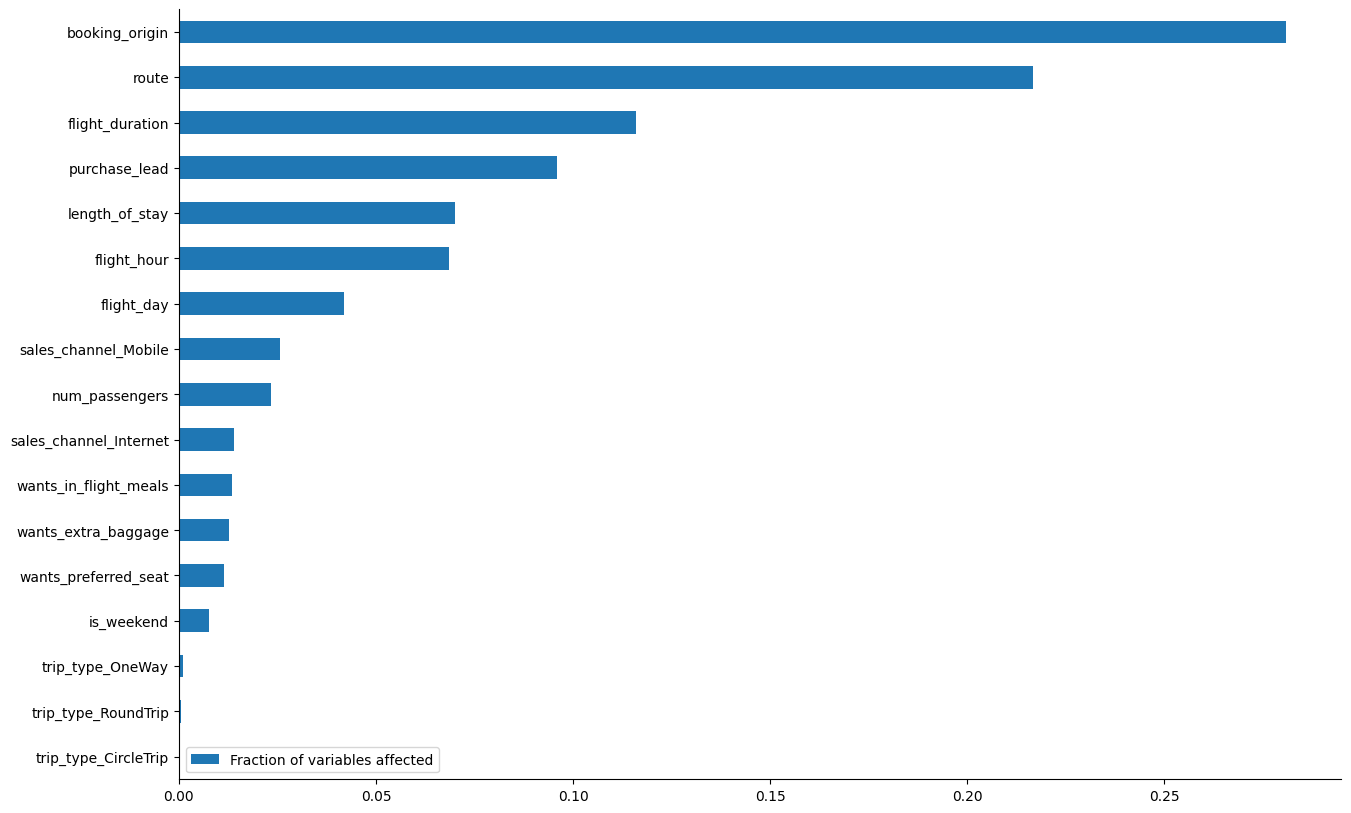

In [ ]:
# Define a random forest classifier
rf = RandomForestClassifier()

# Fit the random forest classifier on the training set
rf.fit(X_train_scaled, y_train.values.ravel())

# Plot the feature importance using a horizontal bar chart
feat_scores = pd.DataFrame({"Fraction of variables affected": rf.feature_importances_}, index=X.columns)
feat_scores = feat_scores.sort_values(by="Fraction of variables affected")
feat_scores.plot(kind="barh", figsize=(15, 10))
sns.despine()


#Modeling


## Logistic Regression(Baseline_model)

In [ ]:
# create a logistic regression model
model = LogisticRegression(C=500.0, random_state=42, solver='newton-cg')

# train the model on the scaled training data
model.fit(X_train_scaled, y_train)

# evaluate the model on the scaled testing data
accuracy = model.score(X_test_scaled, y_test)
# Create the predictions
y_predict = model.predict(X_test_scaled)
print("Accuracy:", accuracy)

Accuracy: 0.7632628172053099


In [ ]:
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.76      0.75      0.76     10509
           1       0.76      0.77      0.77     10810

    accuracy                           0.76     21319
   macro avg       0.76      0.76      0.76     21319
weighted avg       0.76      0.76      0.76     21319



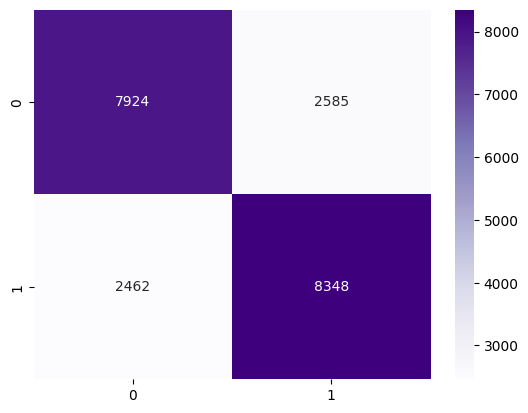

In [ ]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot = True,cmap = 'Purples',fmt='g');

## Xgboost Classifier

In [ ]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier()

# Train the model on the training set
xgb_clf.fit(X_train_scaled, y_train)
# evaluate the model on the scaled testing data
accuracy = xgb_clf.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8913176040151977


In [ ]:
# Predict the labels of the test set
y_pred = xgb_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     10509
           1       0.92      0.86      0.89     10810

    accuracy                           0.89     21319
   macro avg       0.89      0.89      0.89     21319
weighted avg       0.89      0.89      0.89     21319



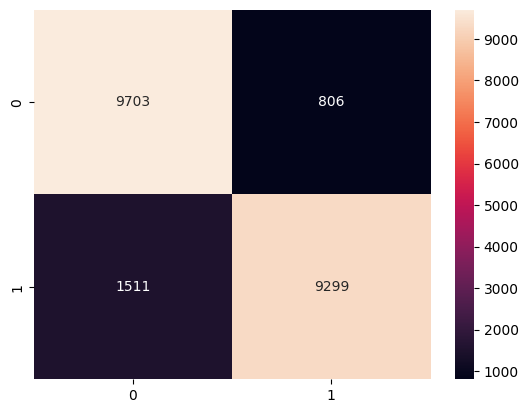

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True,fmt='g');

#Catboost Classifier

In [ ]:
#Define the catboost classifier
catboost_clf = CatBoostClassifier(iterations=500,l2_leaf_reg=6, loss_function='Logloss',  learning_rate=0.1, 
                                     depth= 4, random_state = 69, verbose = False)
# Train the model on the training set
catboost_clf.fit(X_train_scaled, y_train)

In [ ]:
# evaluate the model on the scaled testing data
accuracy2 = catboost_clf.score(X_test_scaled, y_test)
print("Accuracy:", accuracy2)

Accuracy: 0.8946899333896238


In [ ]:
# Predict the labels of the test set
y_pred2 = catboost_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10432
           1       0.93      0.86      0.89     10886

    accuracy                           0.89     21318
   macro avg       0.90      0.90      0.89     21318
weighted avg       0.90      0.89      0.89     21318



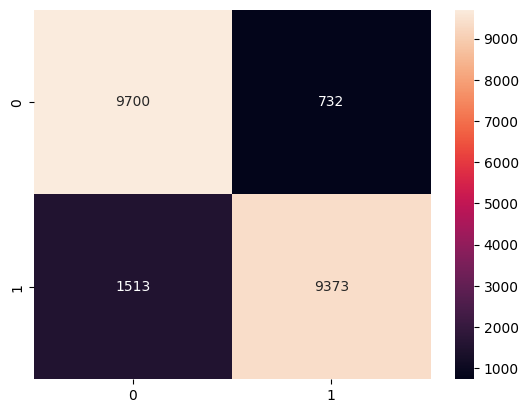

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True,fmt='g');

# Model Evaluation

In [ ]:
#Evaluate the the 3 models using ROC curves, AUC scores and learning curves.
# ROC curve
fpr1, tpr1, thresh1 = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, xgb_clf.predict_proba(X_test_scaled)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, catboost_clf.predict_proba(X_test_scaled)[:, 1], pos_label = 1)


In [ ]:
# AUC score
auc_score1 = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
auc_score2 = roc_auc_score(y_test, xgb_clf.predict_proba(X_test_scaled)[:, 1])
auc_score3 = roc_auc_score(y_test, catboost_clf.predict_proba(X_test_scaled)[:, 1])
print("Logistic Regression: ", auc_score1) # Logistic Regression
print("Xgboost:", auc_score2) # Xgboost
print("Catboost: ", auc_score3) # Catboost

Logistic Regression:  0.8377747881629358
Xgboost: 0.9615287105758057
Catboost:  0.9604350597280348


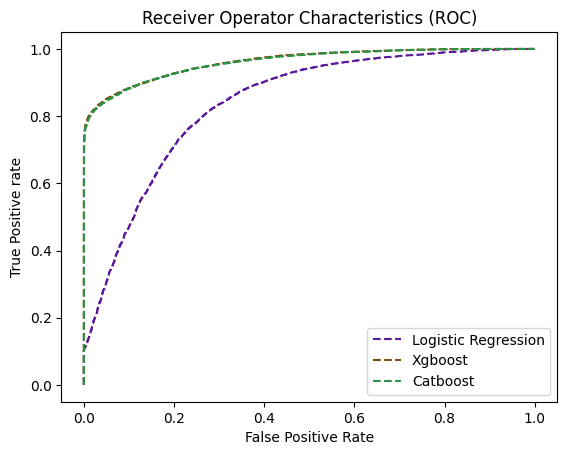

In [ ]:
#Plotting ROC curves for multiple classifiers
#Plotting ROC curve for logistic regression
plt.plot(fpr1, tpr1, linestyle = "--", color = "#5a189a", label = "Logistic Regression")
#Plotting ROC curve for Xgboost
plt.plot(fpr2, tpr2, linestyle = "--", color = "#76520e", label = "Xgboost")
#Plotting ROC curve for Catboost
plt.plot(fpr3, tpr3, linestyle = "--", color = "#2b9348", label = "Catboost")
#Setting plot title and axis labels
plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
#Adding a legend to the plot with the location "best"
plt.legend(loc = 'best')
#Saving the plot as a file named "ROC" with a dpi of 300
plt.savefig('ROC', dpi = 300)
#Displaying the plot
plt.show()

In [ ]:
# create a helper function to plot multi learning curves
def plot_multi_learning_curves(estimator, title):

  train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X_train_scaled, y=y_train,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                      n_jobs=1,verbose = False)
  # Calculate training and test mean and std
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)
  # Plot the learning curve
  plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
  plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
  plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
  plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
  plt.title(title)
  plt.xlabel('Training Data Size')
  plt.ylabel('Model accuracy')
  plt.grid()
  plt.legend(loc='lower right')
  return plt

Streaming output truncated to the last 5000 lines.
4:	learn: 0.5842443	total: 46.4ms	remaining: 9.23s
5:	learn: 0.5706632	total: 55.8ms	remaining: 9.25s
6:	learn: 0.5590285	total: 65.1ms	remaining: 9.24s
7:	learn: 0.5466218	total: 74.6ms	remaining: 9.25s
8:	learn: 0.5362201	total: 84.2ms	remaining: 9.27s
9:	learn: 0.5274457	total: 93.7ms	remaining: 9.27s
10:	learn: 0.5167570	total: 106ms	remaining: 9.5s
11:	learn: 0.5091708	total: 115ms	remaining: 9.47s
12:	learn: 0.5022197	total: 125ms	remaining: 9.49s
13:	learn: 0.4955086	total: 134ms	remaining: 9.43s
14:	learn: 0.4888162	total: 145ms	remaining: 9.52s
15:	learn: 0.4837192	total: 154ms	remaining: 9.46s
16:	learn: 0.4761571	total: 163ms	remaining: 9.45s
17:	learn: 0.4715861	total: 173ms	remaining: 9.43s
18:	learn: 0.4675458	total: 182ms	remaining: 9.4s
19:	learn: 0.4628453	total: 192ms	remaining: 9.38s
20:	learn: 0.4578619	total: 207ms	remaining: 9.67s
21:	learn: 0.4534929	total: 217ms	remaining: 9.64s
22:	learn: 0.4506221	total: 226ms

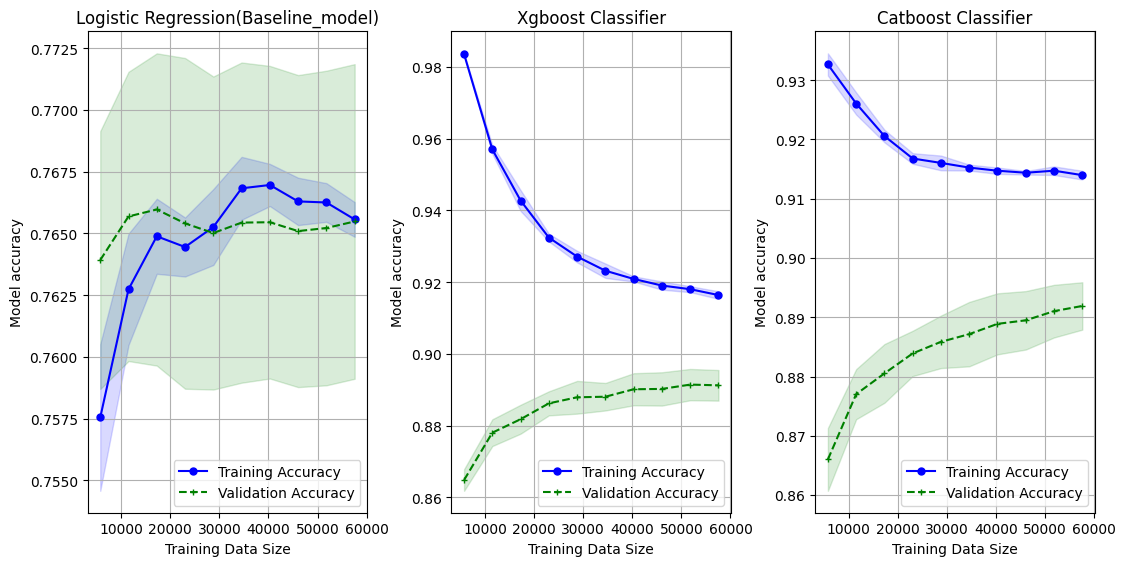

In [ ]:
# Define a list of models to be plotted
lst = [model, xgb_clf, catboost_clf]

# Get the number of models in the list
length = len(lst)

# Define names for the models to be plotted
mods = ['Logistic Regression(Baseline_model)',
        'Xgboost Classifier',
        'Catboost Classifier']

# Create a new figure with the specified size
fig = plt.figure(figsize=(13, 15))

# Loop over each model in the list and plot its learning curve
for i, j, k in itertools.zip_longest(lst, range(length), mods):
    # Create a new subplot in the figure
    plt.subplot(2, 3, j+1)
    
    # Plot the learning curve for the current model
    plot_multi_learning_curves(i, k)
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=.3, hspace=.4)


#Hyperparameter tuning for Xgboost using random search

In [ ]:
# define the hyperparameters 
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

In [ ]:
# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=42),
                                   param_distributions=hyperparameters,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)
# fitting the model for random search 
random_search.fit(X_train_scaled, y_train)

# print best parameter after tuning
print(random_search.best_params_)

{'tree_method': 'exact', 'min_child_weight': 1, 'max_depth': 80, 'lambda': 0.1, 'gamma': 1.0, 'eta': 0.05050505050505051, 'colsample_bytree': 0.6000000000000001, 'alpha': 0.30000000000000004}


Tuned XGboost model

In [ ]:
# Initialize the XGBoost classifier
tuned_xgb = XGBClassifier(tree_method='exact', min_child_weight=1, max_depth=80,
                          gamma=1.0, eta=0.05050505050505051, colsample_bytree=0.6000000000000001,
                          alpha=0.30000000000000004)

# Train the model on the training set
tuned_xgb.fit(X_train_scaled, y_train)
# evaluate the model on the scaled testing data
accuracy = tuned_xgb.score(X_test_scaled, y_test)
print("Accuracy:", accuracy*100)

Accuracy: 90.91420798348891


In [ ]:
# Predict the labels of the test set
y_pred_tun = tuned_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_tun))


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10432
           1       0.95      0.87      0.91     10886

    accuracy                           0.91     21318
   macro avg       0.91      0.91      0.91     21318
weighted avg       0.91      0.91      0.91     21318



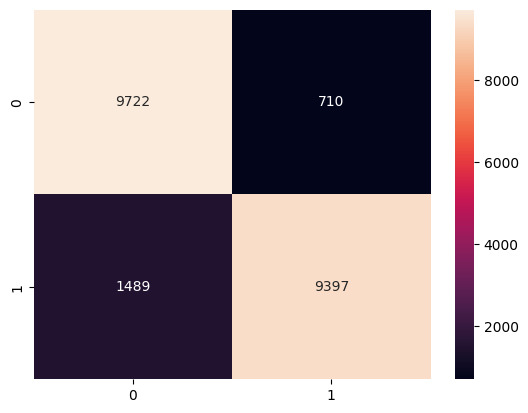

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True,fmt='g');

In [ ]:
# Save the model
filename = 'tuned_xgb.sav'
pickle.dump(tuned_xgb, open(filename, 'wb'))

 XGBoost with hyperparameter have a better prediction and is the best model.



#CONCLUSION

##Models and metrics

### Models

I used three different machines learning algorithms:

      *   Logistic Regression.
      *   Xgboost.
      *   Catboost.

Each of these algorithms was trained using balanced data and evaluated using AUC, recall and learning curves. The best model was XGboost.

###Metrics
Depend on the business needs The most important metric is Precision because the cost of a false positive (predicting a customer will book a holiday with British Airways when they will not) may be higher than the cost of a false negative (predicting a customer will not book a holiday with British Airways when they will).
Therefore,  the focus is on maximizing precision to minimize the number of false positive predictions and ensure that the company only targets customers who are highly likely to book a holiday with British Airways.

##Final results

Based on the results of the tuned XGBOOST model, it appears that it is performing fairly well. Here's a summary of the final results:

* Accuracy: The model achieved an accuracy of ~91% on the labeled data, which suggests that it is correctly predicting the class labels for a large percentage of the customers.
* Precision: The precision of the model was 95% for the class 1 (booking customers), which means that when the model predicted a customer to be a booking customer, it was correct 95% of the time. For the class 0 (non-booking customers), the precision was 88%, which suggests that there may be some false positives in the predictions.
* Recall: The recall of the model was 87% for class 1 (booking customers) and 95% for class 0 (non-booking customers). This means that the model was able to correctly identify 87% of the booking customers and 95% of the non-booking customers.

Overall, these results suggest that the tuned XGBOOST model is performing well and is accurately predicting the class labels for a majority of the customers. However, it may be worth investigating further to determine why there are some false positives for the non-booking customers and how this could be improved.